In [ ]:
!pip install pyspark py4j

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('weather_data_pyspark').getOrCreate()
df = spark.read.csv("/content/Weather Training Data.csv", header=True, inferSchema=True)

In [ ]:
# weather_loader.py
from pathlib import Path
from collections.abc import Iterable
from typing import Union, Optional

from pyspark.sql import SparkSession, DataFrame


class WeatherLoader:
    def __init__(self, file_paths: Union[str, Path, Iterable[Union[str, Path]]], spark: Optional[SparkSession] = None):
        # Always store as a list of strings
        if isinstance(file_paths, (str, Path)):
            self.file_paths = [str(file_paths)]
        elif isinstance(file_paths, Iterable):
            self.file_paths = [str(p) for p in file_paths]
        else:
            raise TypeError("file_paths must be a path or an iterable of paths/strings")

        # Create a SparkSession if one wasn't provided
        self.spark = spark or SparkSession.builder.appName("WeatherLoader").getOrCreate()

        # Options to mimic pandas read_csv defaults
        self._header = True
        self._infer_schema = True
        self._mode = "PERMISSIVE"  # tolerate bad lines

    def load(self) -> DataFrame:
        """
        Load the first CSV file (original behavior).
        Returns a Spark DataFrame.
        """
        path = self.file_paths[0]
        try:
            df = (
                self.spark.read
                .option("header", self._header)
                .option("inferSchema", self._infer_schema)
                .option("mode", self._mode)
                .csv(path)
            )
            return df
        except Exception as e:
            print(f"Error loading {path}: {e}")
            raise

In [ ]:
# weather_processor_spark.py
import logging
from collections.abc import Iterator
import matplotlib.pyplot as plt

# NEW: Spark imports
from pyspark.sql import DataFrame, functions as F, types as T

# NEW (tiny): for plotting a small summary as a pandas Series
import pandas as pd

logger = logging.getLogger(__name__)

class WeatherProcessor:
    def __init__(self, df: DataFrame):
        # df is now a Spark DataFrame (minimal change: just be explicit)
        self.df = df
        logger.debug("Initialized WeatherProcessor")

    def __iter__(self):
        """Return iterator class"""
        return WeatherStatsIterator(self.df)

    def generate_stats(self):
        """
        Generator that yields statistics for each numeric column (Spark version).
        Minimal changes: same return shape as before; internal logic uses Spark.
        """
        # NEW: determine numeric columns from Spark schema
        numeric_cols = [
            f.name for f in self.df.schema.fields
            if isinstance(f.dataType, T.NumericType)
        ]

        for col in numeric_cols:
            # Count non-nulls; Spark F.count ignores nulls
            non_null = self.df.select(F.count(F.col(col))).collect()[0][0]
            if non_null == 0:
                logger.warning(f"Column '{col}' contains no numeric data after dropping NA values")
                continue

            # Mean / Min / Max in one pass
            row = self.df.agg(
                F.avg(F.col(col)).alias("mean"),
                F.min(F.col(col)).alias("min"),
                F.max(F.col(col)).alias("max")
            ).collect()[0]
            mean_val = row["mean"]
            min_val = row["min"]
            max_val = row["max"]

            # Median via approxQuantile (very common for Spark)
            # relError=0.01 ~ 1% relative error (tweak if needed)
            median_val = self.df.approxQuantile(col, [0.5], 0.01)[0]

            # Mode: most frequent non-null value
            mode_row = (
                self.df.groupBy(F.col(col))
                       .agg(F.count("*").alias("cnt"))
                       .orderBy(F.desc("cnt"))
                       .limit(1)
                       .collect()
            )
            mode_str = mode_row[0][0] if mode_row else "N/A"

            stats = {
                "column": col,
                "mean": round(float(mean_val), 2) if mean_val is not None else None,
                "median": round(float(median_val), 2) if median_val is not None else None,
                "mode": mode_str,
                "range": round(float(max_val - min_val), 2) if max_val is not None and min_val is not None else None,
            }

            logger.debug(f"Generated stats for column '{col}': {stats}")
            yield stats

    def print_descriptive_stats(self):
        """Print descriptive statistics (same output format as before)."""
        try:
            for stats in self.generate_stats():
                print(f"\nColumn: {stats['column']}")
                # Handle potential None if a stat can’t be computed
                mean_out   = f"{stats['mean']:.2f}"   if isinstance(stats["mean"], (int, float)) else "N/A"
                median_out = f"{stats['median']:.2f}" if isinstance(stats["median"], (int, float)) else "N/A"
                range_out  = f"{stats['range']:.2f}"  if isinstance(stats["range"], (int, float)) else "N/A"
                mode_out   = stats["mode"]

                print(f"  Mean   : {mean_out}")
                print(f"  Median : {median_out}")
                print(f"  Mode   : {mode_out}")
                print(f"  Range  : {range_out}")

        except Exception as e:
            logger.error(f"Error calculating descriptive statistics: {str(e)}")
            raise

    def visualize_data(self):
        """
        Visualize the average of selected numeric weather columns as a bar chart.
        Minimal change: compute means in Spark, convert tiny result to pandas for plotting.
        """
        columns_to_plot = ["MinTemp", "MaxTemp"]

        existing_cols = [c for c in columns_to_plot if c in self.df.columns]
        if not existing_cols:
            logger.warning("None of the selected columns exist in the DataFrame.")
            return

        # Compute means in Spark, collect a single row, convert to pandas Series for plotting
        agg_exprs = [F.avg(F.col(c)).alias(c) for c in existing_cols]
        row = self.df.select(*agg_exprs).collect()[0]
        means_dict = {c: row[c] for c in existing_cols if row[c] is not None}

        if not means_dict:
            logger.warning("No numeric values found for the selected columns.")
            return

        means = pd.Series(means_dict)

        # Plot as a bar chart (same look & feel)
        plt.figure(figsize=(10, 6))
        means.plot(kind="bar", color="skyblue")
        plt.title("Average Min and Max Temperature")
        plt.ylabel("Average Temperature (Celsius)")
        plt.xticks(rotation=45, ha="right")
        plt.grid(axis="y", alpha=0.3)
        plt.tight_layout()
        plt.show()

        return means


class WeatherStatsIterator(Iterator):
    """Iterator class for WeatherProcessor that iterates over weather statistics (Spark version)."""
    def __init__(self, df: DataFrame):
        self.df = df
        # NEW: numeric columns via Spark schema
        self.columns = [
            f.name for f in df.schema.fields
            if isinstance(f.dataType, T.NumericType)
        ]
        self.current = 0
        self.max_index = len(self.columns)
        logger.debug("Initialized WeatherStatsIterator")

    def __next__(self):
        while self.current < self.max_index:
            col = self.columns[self.current]
            self.current += 1

            # non-null count
            non_null = self.df.select(F.count(F.col(col))).collect()[0][0]
            if non_null == 0:
                logger.warning(f"Column '{col}' contains no numeric data after dropping NA values")
                continue  # move to next column

            row = self.df.agg(
                F.avg(F.col(col)).alias("mean"),
                F.min(F.col(col)).alias("min"),
                F.max(F.col(col)).alias("max")
            ).collect()[0]
            mean_val = row["mean"]
            min_val = row["min"]
            max_val = row["max"]

            median_val = self.df.approxQuantile(col, [0.5], 0.01)[0]

            mode_row = (
                self.df.groupBy(F.col(col))
                       .agg(F.count("*").alias("cnt"))
                       .orderBy(F.desc("cnt"))
                       .limit(1)
                       .collect()
            )
            mode_str = mode_row[0][0] if mode_row else "N/A"

            return {
                "column": col,
                "mean": round(float(mean_val), 2) if mean_val is not None else None,
                "median": round(float(median_val), 2) if median_val is not None else None,
                "mode": mode_str,
                "range": round(float(max_val - min_val), 2) if max_val is not None and min_val is not None else None,
            }

        # no more columns
        raise StopIteration

In [ ]:
# weather_storage.py
from pyspark.sql import DataFrame

class WeatherStorage:
    def __init__(self, out_path="/content/descriptive_stats"):
        # Spark writes *folders*, not single files by default
        self.out_path = out_path

    def save_stats(self, df: DataFrame):
        try:
            (
                df.coalesce(1)  # optional: write a single output file
                  .write
                  .option("header", True)
                  .mode("overwrite")
                  .csv(self.out_path)
            )
            print(f"Successfully saved statistics to {self.out_path}")
        except Exception:
            raise


Loading weather data
Successfully loaded data with 99516 rows
Processing data

Column: MinTemp
  Mean   : 12.18
  Median : 11.90
  Mode   : 11.0
  Range  : 42.40

Column: MaxTemp
  Mean   : 23.22
  Median : 22.60
  Mode   : 20.0
  Range  : 52.20

Column: Rainfall
  Mean   : 2.35
  Median : 0.00
  Mode   : 0.0
  Range  : 371.00

Column: Evaporation
  Mean   : 5.46
  Median : 4.60
  Mode   : None
  Range  : 86.20

Column: Sunshine
  Mean   : 7.62
  Median : 8.40
  Mode   : None
  Range  : 14.50

Column: WindGustSpeed
  Mean   : 39.98
  Median : 39.00
  Mode   : None
  Range  : 129.00

Column: WindSpeed9am
  Mean   : 14.00
  Median : 13.00
  Mode   : 9
  Range  : 130.00

Column: WindSpeed3pm
  Mean   : 18.65
  Median : 19.00
  Mode   : 17
  Range  : 87.00

Column: Humidity9am
  Mean   : 68.87
  Median : 70.00
  Mode   : 99
  Range  : 100.00

Column: Humidity3pm
  Mean   : 51.43
  Median : 52.00
  Mode   : None
  Range  : 100.00

Column: Pressure9am
  Mean   : 1017.68
  Median : 1017.70
  

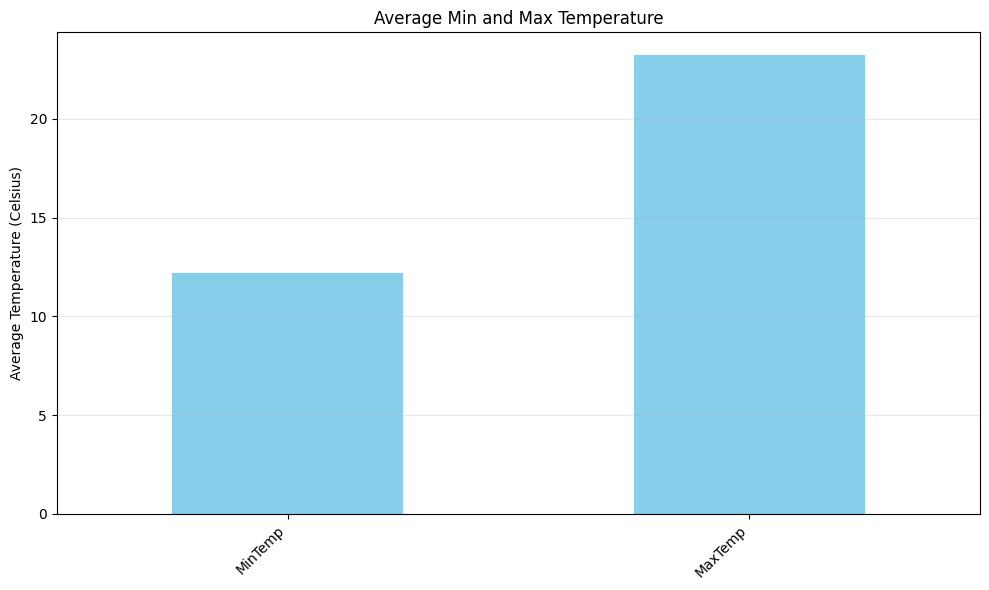

Saving statistics
Successfully saved statistics to /content/descriptive_stats


In [ ]:
if __name__ == "__main__":
    try:
        # Load in weather training data
        print("Loading weather data")
        loader = WeatherLoader("/content/Weather Training Data.csv", spark=spark)
        df = loader.load()
        print(f"Successfully loaded data with {df.count()} rows")

        # Process raw data
        print("Processing data")
        processor = WeatherProcessor(df)

        processor.print_descriptive_stats()
        # Visualize data
        processor.visualize_data()

        # Save to storage
        print("Saving statistics")
        storage = WeatherStorage()
        storage.save_stats(df)

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise